In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.ticker as ticker

from scipy.stats import norm

import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


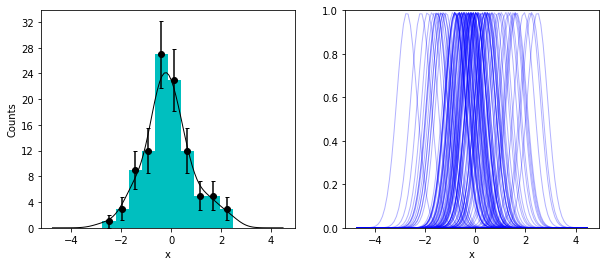

In [2]:
mean = 0.0
std = 1.0
N = 100
x = np.random.normal(loc=mean,scale=std,size=N)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10, 4))

ax1.set_ylabel('Counts')
ax1.set_xlabel('x')
ax1.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

bin_counts, bin_edges, _ = ax1.hist(x,bins=10, color='c')
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
error = np.array([np.sqrt(i) for i in bin_counts])

ax1.errorbar(x=bin_centres, y=bin_counts, yerr=error, fmt='o', capsize=2, color='black')



z = np.linspace(x.min()-2, x.max()+2, 100)
sigma = 1.06*x.std()*pow(x.size,-1/5)
gauss = np.array([norm.pdf(z, loc = i, scale = sigma) for i in x])

ax2.set_ylim(0)
ax2.set_xlabel('x')

for i in gauss:
    ax2.plot(z, i, 'k-', color='b', lw=1, alpha=0.3)

    
sum_gauss = np.sum(gauss, axis = 0)

I = sc.integrate.trapz(sum_gauss, z) #normalization

width = bin_edges[1] - bin_edges[0]
area = width * N #area of the histogram

ax1.plot(z, sum_gauss*area/I, color ="black", linewidth = 1)

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2021-12-15 02:38:23--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [following]
--2021-12-15 02:38:24--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3df7e35dc4e4db41305ea5a2f4.dl.dropboxusercontent.com/cd/0/inline/Bb2pXiJSS5tWP06jkniwiym9omWrVxiXcYd1IQVWdVTbpAiwRo-BwDIdx_AF9G0SHv9mYjZCmEeOkb9ZiJ3vqa10AQlyugpEssA_WS0ENGrdETsIBBvbX5flJ7CFmc-92GHvyuodZNYQQXWY1MrnKEUb/file# [following]
--2021-12-15 02:38:24--  https://uc3df7e35dc4e4db41305ea5a2f4.dl.dropboxusercontent.com/cd/0/inline/Bb2pXiJSS5tWP06jkniwiym9omWrVx

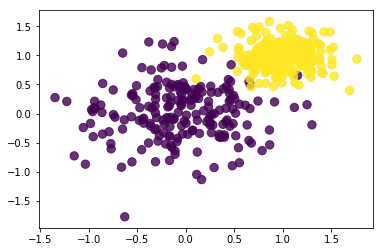

In [3]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

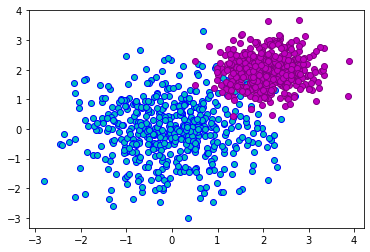

In [4]:
cat1 = np.random.normal(loc=0.0, scale=1, size=(500,2))
cat2 = np.random.normal(loc=2.0, scale=0.5, size=(500,2))

plt.scatter(cat1[:,0], cat1[:,1], marker='o', color='c', edgecolor='b')
plt.scatter(cat2[:,0], cat2[:,1], marker='o', color='m', edgecolor='purple')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [5]:
#!wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

In [6]:
df = pd.DataFrame(np.load("residuals_261.npy", allow_pickle=True).item())
df

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [7]:
new_df = df[np.absolute(df['residuals']) < 2]
new_df

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [8]:
lin_reg = sc.stats.linregress(df['residuals'],df['distances'])
print(lin_reg)

LinregressResult(slope=0.07989758117486033, intercept=9.820720326596168, rvalue=0.056597511872424025, pvalue=2.295857625392191e-09, stderr=0.01336015576834192, intercept_stderr=0.05623169425742934)


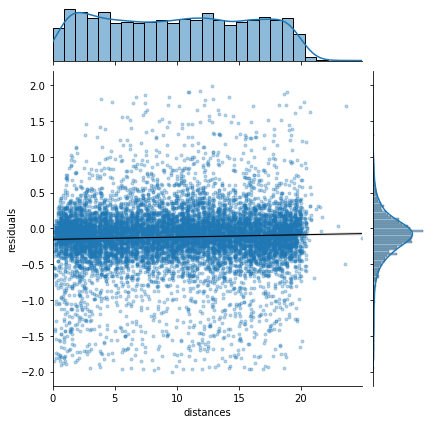

In [9]:
sns.jointplot(x='distances', y='residuals', data=new_df, kind="reg", marker='.', 
                 joint_kws={"line_kws":{"color":"black", "linewidth":1},"scatter_kws":{"alpha": 0.3}})

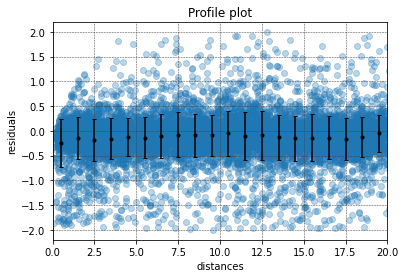

In [10]:
hist, bin_edges= np.histogram(df['distances'],bins=20, range=(0,20))

x = (bin_edges[:-1] + bin_edges[1:]) / 2 #bin_centres

y = []
erry = []
for i in range(1,len(bin_edges)):
    y.append(new_df[(new_df['distances']>=bin_edges[i-1])&(new_df['distances']<=bin_edges[i])]['residuals'].mean())
    erry.append(new_df[(new_df['distances']>=bin_edges[i-1])&(new_df['distances']<=bin_edges[i])]['residuals'].std())


fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Profile plot')
ax.set_ylabel('residuals')
ax.set_xlabel('distances')
ax.set_xlim(0, 20)
ax.grid(linestyle="--", linewidth=0.5, color='.25')
ax.errorbar(x, y, erry, linestyle='none', marker='.', capsize=2, color='black')
ax.scatter(x='distances', y='residuals', data=new_df, alpha = 0.3)